# 1 + 1 = 1 or Record Deduplication with Python
Flávio Juvenal  
[@flaviojuvenal](https://twitter.com/flaviojuvenal)  

<p>
    Partner at <a href="http://www.vinta.com.br?dedupe-slides=1"><img class="vinta_logo" style="display: inline-block; margin-left: 0;" src="vinta.png" width=300></a>
</p>

In [1]:
import warnings; warnings.simplefilter('ignore')
import logging; logging.disable(level=logging.INFO)

<p style="font-size: 2em; text-weight: bold">
    Slides available at: <a href="http://bit.ly/pybay-dupe">bit.ly/pybay-dupe</a> (open as Desktop)
</p>
<p>
    Jupyter Notebook source at: <a href="https://github.com/vintasoftware/deduplication-slides/">github.com/vintasoftware/deduplication-slides/</a>
</p>

## Real world data is a mess!
Probably you dealt with data like this before:

In [2]:
import pandas as pd

data = [
    ("Art's Delicatessen","12224 Ventura Blvd","Studio City"),
    ("Arts Deli","12224 Ventura Blvd.","LA"),
    ("Art's Deli and Restaurant","12224 Ventura Boulevard","Los Angeles"),
    ("Art's Delicatessen & Restaurant","12220 Ventura Blvd.","LA"),
    ("Fringale", "570 4th St.", "San Francisco"),
    ("Fringale Restaurant", "570 Fourth Street", "SF"),
]

df = pd.DataFrame(data, columns=['restaurant', 'address', 'city'])

In [3]:
df

,restaurant,address,city
0,Art's Delicatessen,12224 Ventura Blvd,Studio City
1,Arts Deli,12224 Ventura Blvd.,LA
2,Art's Deli and Restaurant,12224 Ventura Boulevard,Los Angeles
3,Art's Delicatessen & Restaurant,12220 Ventura Blvd.,LA
4,Fringale,570 4th St.,San Francisco
5,Fringale Restaurant,570 Fourth Street,SF


The solution is to perform **Deduplication** (aka [Record Linkage](https://en.wikipedia.org/wiki/Record_linkage)). It works by joining records in a **fuzzy way** using data like names, addresses, phone numbers, dates, etc.

In [4]:
import jellyfish

In [5]:
jellyfish.jaro_winkler("Art's Delicatessen", "Arts Deli")

0.8833333333333334

In [6]:
jellyfish.jaro_winkler("Art's Delicatessen", "Fringale")

0.5009259259259259

## 0/4 - Preprocessing
Without unique identifiers, we need to match records by fuzzy data like:
- Names
- Addresses
- Phone Numbers

So it's important to **clean** them for matching.

### Cleaning names (companies or people)

Let's use string functions and regexes to **normalize** names and remove undesired variations:

In [7]:
import numpy as np
import re
import pprint


company_names = company_names_dirty = [
    'APPLE COMPUTER INC',
    'APPLE COMPUTER, INC.',
    'APPLE INC',
    'Apple Computer',
    'Apple Computer Co.',
    'Apple Computer Company',
    'Apple Computer Inc',
    'Apple Computer Incorporated',
    'Apple Computer, Inc.',
    'Apple Inc',
    'Apple Inc.',
    'Apple, Inc.'
]

In [8]:
print("Lower case:")
company_names = [c.lower() for c in company_names]
pprint.pprint(company_names)

Lower case:
['apple computer inc',
 'apple computer, inc.',
 'apple inc',
 'apple computer',
 'apple computer co.',
 'apple computer company',
 'apple computer inc',
 'apple computer incorporated',
 'apple computer, inc.',
 'apple inc',
 'apple inc.',
 'apple, inc.']


In [9]:
print("Remove irrelevant separators:")
irrelevant_regex = re.compile(r'[^a-z0-9\s]')
company_names = [irrelevant_regex.sub(' ', c) for c in company_names]
pprint.pprint(company_names)

Remove irrelevant separators:
['apple computer inc',
 'apple computer  inc ',
 'apple inc',
 'apple computer',
 'apple computer co ',
 'apple computer company',
 'apple computer inc',
 'apple computer incorporated',
 'apple computer  inc ',
 'apple inc',
 'apple inc ',
 'apple  inc ']


In [10]:
print("Remove multi-spaces:")
multispace_regex = re.compile(r'\s\s+')
company_names = [multispace_regex.sub(' ', c).strip() for c in company_names]
pprint.pprint(company_names)

Remove multi-spaces:
['apple computer inc',
 'apple computer inc',
 'apple inc',
 'apple computer',
 'apple computer co',
 'apple computer company',
 'apple computer inc',
 'apple computer incorporated',
 'apple computer inc',
 'apple inc',
 'apple inc',
 'apple inc']


We can also use the natural language processing library [**probablepeople**](https://github.com/datamade/probablepeople) to **parse company names** and extract just the parts we want (or break into parts and match by part on the comparison step later):

In [11]:
import probablepeople as pp

pp.parse("Apple Computer Incorporated")

[('Apple', 'CorporationName'),
 ('Computer', 'CorporationName'),
 ('Incorporated', 'CorporationLegalType')]

In [12]:
company_names_alternative_1 = [
    [
        parsed_value
        for parsed_value, parsed_type
        in pp.parse(c)
        if parsed_type == 'CorporationName'
    ]
    for c in company_names_dirty
]
pprint.pprint(company_names_alternative_1)

[['APPLE', 'COMPUTER'],
 ['APPLE', 'COMPUTER,'],
 ['APPLE'],
 ['Apple', 'Computer'],
 ['Apple', 'Computer'],
 ['Apple', 'Computer'],
 ['Apple', 'Computer'],
 ['Apple', 'Computer'],
 ['Apple', 'Computer,'],
 ['Apple'],
 ['Apple'],
 ['Apple,']]


probablepeople, as the name suggests, can parse **people** names too:

In [13]:
pp.parse('Mr. Guido van Rossum')

[('Mr.', 'PrefixMarital'),
 ('Guido', 'GivenName'),
 ('van', 'Surname'),
 ('Rossum', 'Surname')]

### Cleaning addresses

Geocoding street addresses, i.e., converting them to **latitude/longitude** is very useful for matching, because geocoders usually clean irrelevant address variations. Also, having lat/lng enables the calculation of geometric distances between addresses.

In [14]:
import requests
import geocoder

full_addresses = [
    "20863 Stevens Creek Blvd., Suite 300, 95015, CUPERTINO, CA, US",
    "20863 STEVENS CREEK Boulevard STE 330, 95014, Cupertio, CA, USA",
]

full_addresses_latlng = []
with requests.Session() as session:
    for a in full_addresses:
        a_geocoded = geocoder.google(a, session=session)
        full_addresses_latlng.append(a_geocoded.latlng)

address_latlng = list(zip(full_addresses, full_addresses_latlng))

In [15]:
pprint.pprint(address_latlng)

[('20863 Stevens Creek Blvd., Suite 300, 95015, CUPERTINO, CA, US', None),
 ('20863 STEVENS CREEK Boulevard STE 330, 95014, Cupertio, CA, USA', None)]


Google geocoder is able to ignore the following variations:
- Lower/upper case
- Blvd. vs Boulevard
- Suite 300 vs STE 330
- Zipcode 95015 vs 95014
- Cupertino vs Cupertio
- US vs USA

### Cleaning phone numbers

[**phonenumbers**](https://github.com/daviddrysdale/python-phonenumbers) library can **normalize** phone numbers from many countries:

In [16]:
import phonenumbers

print("Phone number normalization:")
phone = "(541) 555-3010"
print(phone, '->')
print(
    phonenumbers.format_number(
        phonenumbers.parse(phone, 'US'),
        phonenumbers.PhoneNumberFormat.E164)
)

Phone number normalization:
(541) 555-3010 ->
+15415553010


### Cleaning a real dataset

Now we know the tools, let's **grab a dataset to preprocess and go on the other deduplication steps**. Our dataset is based* on the [Restaurant](https://www.cs.utexas.edu/users/ml/riddle/data.html) dataset, a well-known dataset used by researchers. It's made of 881 restaurant records from the Fodor's and Zagat's restaurant guides that contains 150 duplicates.

\* We've introduced some changes that you can check by doing a `diff restaurant.original.csv restaurant.csv`

In [17]:
df_with_truth = pd.read_csv('restaurant.csv', skip_blank_lines=True)
df_with_truth.head(9)

,name,addr,city,phone,type,cluster
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles,310/246-1501,american,0
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles,310-246-1501,steakhouses,0
2,arnie morton,435 s. la cienega boulevard,los angeles,310-246-1501,steakhouses,0
3,art's delicatessen,12224 ventura blvd.,studio city,818/762-1221,american,1
4,art's deli,12224 ventura blvd.,studio city,818-762-1221,delis,1
5,art's deli,12224 ventura blvd.,los angeles,818-762-1221,delis,1
6,hotel bel-air,701 stone canyon rd.,bel air,310/472-1211,californian,2
7,bel-air hotel,701 stone canyon rd.,bel air,310-472-1211,californian,2
8,bel-air,701 stone canyon road,bel air,(310) 472-1211,american,2


The dataset comes with the true matches indicated by the 'cluster' column. We'll remove it. We'll also remove the 'phone' and 'type' to makes things more difficult:

In [18]:
df = df_with_truth.drop(columns=['cluster', 'phone', 'type'])
df.head(9)

,name,addr,city
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles
2,arnie morton,435 s. la cienega boulevard,los angeles
3,art's delicatessen,12224 ventura blvd.,studio city
4,art's deli,12224 ventura blvd.,studio city
5,art's deli,12224 ventura blvd.,los angeles
6,hotel bel-air,701 stone canyon rd.,bel air
7,bel-air hotel,701 stone canyon rd.,bel air
8,bel-air,701 stone canyon road,bel air


Now we'll clean the column values! Cleaning **name**:

In [19]:
def assign_no_symbols_name(df):
    return df.assign(
        name=df['name']
             .str.replace(irrelevant_regex, ' ')
             .str.replace(multispace_regex, ' '))

df = assign_no_symbols_name(df)
df.head(9)

,name,addr,city
0,arnie morton s of chicago,435 s. la cienega blv.,los angeles
1,arnie morton s of chicago,435 s. la cienega blvd.,los angeles
2,arnie morton,435 s. la cienega boulevard,los angeles
3,art s delicatessen,12224 ventura blvd.,studio city
4,art s deli,12224 ventura blvd.,studio city
5,art s deli,12224 ventura blvd.,los angeles
6,hotel bel air,701 stone canyon rd.,bel air
7,bel air hotel,701 stone canyon rd.,bel air
8,bel air,701 stone canyon road,bel air


Geocoding **addr**:

In [20]:
all_addresses = df['addr'].str.cat(df['city'], sep=', ').values
unique_addresses = np.unique(all_addresses)
print(len(all_addresses), len(unique_addresses))

881 819


In [21]:
import os.path
import json

geocoding_filename = 'address_to_geocoding.json'

def geocode_addresses(address_to_geocoding):
    remaining_addresses = (
        set(unique_addresses) -
        set(k for k, v in address_to_geocoding.items() if v is not None and 'lat' in v))

    with requests.Session() as session:
        for i, address in enumerate(remaining_addresses):
            print(f"Geocoding {i + 1}/{len(remaining_addresses)}")
            geocode_result = geocoder.google(address, session=session)
            address_to_geocoding[address] = geocode_result.json

        with open(geocoding_filename, 'w') as f:
            json.dump(address_to_geocoding, f, indent=4)

if not os.path.exists(geocoding_filename):
    address_to_geocoding = {}
    geocode_addresses(address_to_geocoding)
else:
    with open(geocoding_filename) as f:
        address_to_geocoding = json.load(f)
    geocode_addresses(address_to_geocoding)
 
address_to_postal = {
    k: v['postal']
    for k, v in address_to_geocoding.items()
    if v is not None and 'postal' in v
}
address_to_latlng = {
    k: (v['lat'], v['lng'])
    for k, v in address_to_geocoding.items()
    if v is not None
}
print(f"Failed to get postal from {len(address_to_geocoding) - len(address_to_postal)}")
print(f"Failed to get latlng from {len(address_to_geocoding) - len(address_to_latlng)}")

Failed to get postal from 7
Failed to get latlng from 0


In [22]:
def assign_postal_lat_lng(df):
    addresses = df['addr'].str.cat(df['city'], sep=', ')
    addresses_to_postal = [address_to_postal.get(a) for a in addresses]
    addresses_to_lat = [address_to_latlng[a][0] if a in address_to_latlng else None for a in addresses]
    addresses_to_lng = [address_to_latlng[a][1] if a in address_to_latlng else None for a in addresses]

    return df.assign(postal=addresses_to_postal, lat=addresses_to_lat, lng=addresses_to_lng)

df = assign_postal_lat_lng(df)
df.head(6)

,name,addr,city,postal,lat,lng
0,arnie morton s of chicago,435 s. la cienega blv.,los angeles,90048,34.070609,-118.376722
1,arnie morton s of chicago,435 s. la cienega blvd.,los angeles,90048,34.070609,-118.376722
2,arnie morton,435 s. la cienega boulevard,los angeles,90048,34.070609,-118.376722
3,art s delicatessen,12224 ventura blvd.,studio city,91604,34.142966,-118.399469
4,art s deli,12224 ventura blvd.,studio city,91604,34.142966,-118.399469
5,art s deli,12224 ventura blvd.,los angeles,91604,34.142966,-118.399469


Now, with a clean dataset, we can move to the next step.

## 1/4 - Indexing

To explain the following deduplication steps, we'll use the Python libary **recordlinkage**, aka **[Python Record Linkage Toolkit](http://recordlinkage.readthedocs.io/en/stable/)**. We choose it because it doesn't abstract too much the details of the process, even though it has a simple API.

We have the cleaned records, we now need the pairs we want to compare to find matches.
To **produce the pairs**, we could do a "full" index, i.e., all records against all records:

In [23]:
import recordlinkage as rl
from recordlinkage.index import Full

full_indexer = Full()
pairs = full_indexer.index(df)

print(f"Full index: {len(df)} records, {len(pairs)} pairs")

Full index: 881 records, 387640 pairs


The formula for the total number of pairs is:  
`len(df) * (len(df) - 1) / 2 == 387640`

<div><img style="display: block; margin: 0 auto;" src="full-indexing.png?" width=800></div>

The number of pairs grows too fast as the number of records grows: it **grows quadratically**.
That's why we need **indexing**. We need to produce only pairs that are good candidates of being duplicates to avoid wasting too much time.

Indexing is also called **blocking** because the trivial way to index is to produce pairs that have **some column value**. By doing this, we produce blocks of record pairs and compare only those in the same block:

<div><img style="display: block; margin: 0 auto;" src="standard-blocking.png?" width=800></div>

Below we produce pairs that have **equal values for postal** code:

In [24]:
from recordlinkage.index import Block

postal_indexer = Block('postal')
postal_index_pairs = postal_indexer.index(df)

print(f"Postal index: {len(postal_index_pairs)} pairs")

Postal index: 6577 pairs


We could also produce pairs by sorting the unique values of some column and, for each value, getting the records with **neighboring values**. The idea is to produce pairs with close values on some column, like `johnny` and `john` or  `2018-01-02` and `2018-01-05`. It looks like this:

<div><img style="display: block; margin: 0 auto;" src="sorted-neighbourhood.png?" width=800></div>

Below we produce pairs that have **neighboring values for name**:

In [25]:
from recordlinkage.index import SortedNeighbourhood

name_indexer = SortedNeighbourhood('name', window=7)
name_index_pairs = name_indexer.index(df)

print(f"Name index: {len(name_index_pairs)} pairs")

Name index: 3074 pairs


Note that simply sorting values wouldn't be able to get `kamila` and `camila` as neighbors, as sorting is sensitive to the leading characters of strings. There are other ways to index that could handle that, check Christen, chapter 4 [2].

To produce more pairs without introducing redundant pairs, we should **union** different indexes:

In [26]:
pairs = postal_index_pairs.union(name_index_pairs)

print(f"Postal or name index: {len(pairs)} pairs")

Postal or name index: 9455 pairs


In [27]:
# We'll swap the levels of pairs MultiIndex returned by recordlinkage
# to make it simpler to interpret. Here we get the upper triangle of the pairs matrix.
pairs = pairs.swaplevel().sortlevel()[0]

We now have **which pairs** we want to run comparisons on!

## 2/4 - Comparison

Now we want to run comparisons on the indexed pairs to produce **a comparison vector for each pair**. For example:

In [68]:
# TODO
pd.DataFrame([[0.5, 0.8, 0.9, 1]],
             columns=['name', 'addr', 'postal', 'latlng'],
             index=pd.MultiIndex.from_arrays([[100], [200]]))

,,name,addr,postal,latlng
100,200,0.5,0.8,0.9,1


The pair of records `(100, 200)` has:
- Low similarity on `name`s
- Some similarity on `addr`s
- High similarity on `postal`s
- Equal `latlng`s

To compute the comparison vectors for all indexed pairs, we define a **similarity function** for each column:

In [29]:
comp = rl.Compare()
comp.string('name', 'name', method='jarowinkler', label='name')
comp.string('addr', 'addr', method='jarowinkler', label='addr')
comp.string('postal', 'postal', method='jarowinkler', label='postal')
comp.geo('lat', 'lng', 'lat', 'lng', method='exp', scale=0.1, offset=0.05, label='latlng');

For more details on the different similarity functions you can use, check Christen, chapter 5 [2]. Also, check the similarity functions [implemented on recordlikage library](http://recordlinkage.readthedocs.io/en/stable/ref-compare.html).

Now we'll compute the **comparison vectors**:

In [30]:
comparison_vectors = comp.compute(pairs, df)
comparison_vectors.head(5)

name      addr    postal        latlng
0 1  1.000000  0.985507  1.000000  1.000000e+00
  2  0.896000  0.910774  1.000000  1.000000e+00
  3  0.562492  0.593620  0.733333  1.328506e-25
  4  0.581667  0.593620  0.733333  1.328506e-25
  5  0.581667  0.593620  0.733333  1.328506e-25

Now, with our comparison vectors, we'll explore **different ways** to classify them as matches and nonmatches.

## 3/4 - Classification

### Threshold-Based Classification

A simple way to classify comparison vectors as matches or nonmatches is to compute a **weighted average** over the vectors to get a **score**:

In [31]:
scores = np.average(
    comparison_vectors.values,
    axis=1,
    weights=[50, 30, 10, 20])
scored_comparison_vectors = comparison_vectors.assign(score=scores)
scored_comparison_vectors.head(5)

name      addr    postal        latlng     score
0 1  1.000000  0.985507  1.000000  1.000000e+00  0.996047
  2  0.896000  0.910774  1.000000  1.000000e+00  0.928393
  3  0.562492  0.593620  0.733333  1.328506e-25  0.484241
  4  0.581667  0.593620  0.733333  1.328506e-25  0.492957
  5  0.581667  0.593620  0.733333  1.328506e-25  0.492957

By looking at the data, we know record `0` truly matches `1` and `2`, so we'll **classify as a match** any pair with score `>= 0.9`. That's our **threshold**:

In [32]:
df.head(5)

,name,addr,city,postal,lat,lng
0,arnie morton s of chicago,435 s. la cienega blv.,los angeles,90048,34.070609,-118.376722
1,arnie morton s of chicago,435 s. la cienega blvd.,los angeles,90048,34.070609,-118.376722
2,arnie morton,435 s. la cienega boulevard,los angeles,90048,34.070609,-118.376722
3,art s delicatessen,12224 ventura blvd.,studio city,91604,34.142966,-118.399469
4,art s deli,12224 ventura blvd.,studio city,91604,34.142966,-118.399469


In [33]:
matches = scored_comparison_vectors[
    scored_comparison_vectors['score'] >= 0.9]
matches.head(5)

name      addr  postal  latlng     score
0 1  1.000000  0.985507     1.0     1.0  0.996047
  2  0.896000  0.910774     1.0     1.0  0.928393
1 2  0.896000  0.923779     1.0     1.0  0.931940
3 4  0.911111  1.000000     1.0     1.0  0.959596
  5  0.911111  1.000000     1.0     1.0  0.959596

Since we have the true match status on `cluster` column, we can **evaluate** how well our threshold classification did:

In [34]:
golden_pairs = Block('cluster').index(df_with_truth)
golden_pairs = golden_pairs.swaplevel().sortlevel()[0]
print("Golden pairs:", len(golden_pairs))

Golden pairs: 150


In [35]:
found_pairs_set = set(matches.index)

golden_pairs_set = set(golden_pairs)

true_positives = golden_pairs_set & found_pairs_set
false_positives = found_pairs_set - golden_pairs_set
false_negatives = golden_pairs_set - found_pairs_set

print('true_positives total:', len(true_positives))
print('false_positives total:', len(false_positives))
print('false_negatives total:', len(false_negatives))

true_positives total: 129
false_positives total: 3
false_negatives total: 21


We've got a small number of **false positives**. Some are really tricky cases:

In [36]:
print(f"False positives:")
for false_positive_pair in false_positives:
    display(df.loc[list(false_positive_pair)][['name', 'addr', 'city', 'lat', 'lng']])

False positives:


,name,addr,city,lat,lng
762,palm,837 second ave.,new york city,40.751701,-73.971180
763,palm too,840 second ave.,new york city,40.751467,-73.970686


,name,addr,city,lat,lng
196,ritz carlton cafe buckhead,3434 peachtree rd. ne,atlanta,33.850807,-84.364227
198,ritz carlton dining room buckhead,3434 peachtree rd. ne,atlanta,33.850807,-84.364227


,name,addr,city,lat,lng
200,ritz carlton restaurant,181 peachtree st.,atlanta,33.758579,-84.387066
839,ritz carlton cafe atlanta,181 peachtree st.,atlanta,33.758579,-84.387066


On the other hand, we got a lot of **false negatives**. We've **missed** a lot of matches!

In [37]:
print(f"False negatives (sample 10 of {len(false_negatives)}):")
for false_negative_pair in list(false_negatives)[:10]:
    display(df.loc[list(false_negative_pair)][['name', 'addr', 'city', 'lat', 'lng']])

False negatives (sample 10 of 21):


,name,addr,city,lat,lng
170,brasserie le coze,3393 peachtree rd. lenox square mall near ne...,atlanta,33.846181,-84.364109
171,brasserie le coze,3393 peachtree rd.,atlanta,33.846869,-84.362512


,name,addr,city,lat,lng
182,heera of india,595 piedmont ave. rio shopping mall,atlanta,33.795817,-84.370602
183,heera of india,595 piedmont ave.,atlanta,33.770495,-84.381425


,name,addr,city,lat,lng
164,abruzzi,2355 peachtree rd. peachtree battle shopping ...,atlanta,33.820137,-84.387280
165,abruzzi,2355 peachtree rd. ne,atlanta,33.824647,-84.387453


,name,addr,city,lat,lng
28,restaurant katsu,1972 n. hillhurst ave.,los angeles,34.107405,-118.28719
29,katsu,1972 hillhurst ave.,los feliz,34.107405,-118.28719


,name,addr,city,lat,lng
36,locanda veneta,8638 w 3rd,st los angeles,34.073417,-118.381096
37,locanda,w. third st.,st los angeles,34.068944,-118.322451


,name,addr,city,lat,lng
40,the palm,9001 santa monica blvd.,los angeles,34.083064,-118.387282
41,palm the los angeles,9001 santa monica blvd.,w. hollywood,34.083064,-118.387282


,name,addr,city,lat,lng
136,shun lee west,43 w. 65th st.,new york,40.772900,-73.981348
137,shun lee palace,155 e. 55th st.,new york city,40.759428,-73.969068


,name,addr,city,lat,lng
34,locanda veneta,3rd st.,los angeles,33.494790,-112.069374
35,locanda veneta,8638 w. third st.,los angeles,34.073417,-118.381096


,name,addr,city,lat,lng
30,l orangerie,903 n. la cienega blvd.,los angeles,34.087098,-118.376626
31,l orangerie,903 n. la cienega blvd.,w. hollywood,34.100833,-118.325613


,name,addr,city,lat,lng
35,locanda veneta,8638 w. third st.,los angeles,34.073417,-118.381096
37,locanda,w. third st.,st los angeles,34.068944,-118.322451


We've set the weights and the threshold **by guessing**, could we do any better?

### Supervised Classification

Instead of trying to guess weights and thresholds, we can train a **classifier** to learn how to classify matches and nonmatches based on some training data we provide:

In [38]:
df_training = pd.read_csv('restaurant-training.csv', skip_blank_lines=True)
df_training = df_training.drop(columns=['phone'])
df_training

,name,addr,city,type,cluster
0,locanda veneta,3rd st.,los angeles,italian,13
1,locanda veneta,8638 w. third st.,los angeles,italian,13
2,locanda veneta,8638 w 3rd,st los angeles,italian,13
3,cafe lalo,201 w. 83rd st.,new york,coffee bar,26
4,cafe lalo,201 w. 83rd st.,new york city,coffeehouses,26
5,les celebrites,160 central park s,new york,french,42
6,les celebrites,155 w. 58th st.,new york city,french (classic),42
7,second avenue deli,156 2nd ave. at 10th st.,new york,delicatessen,58
8,second avenue deli,156 second ave.,new york city,delis,58
9,smith & wollensky,201 e. 49th st.,new york,american,62


We need to **preprocess** our training data too:

In [39]:
df_training = assign_no_symbols_name(df_training)
df_training = assign_postal_lat_lng(df_training)
df_training.head(5)

,name,addr,city,type,cluster,postal,lat,lng
0,locanda veneta,3rd st.,los angeles,italian,13,None,33.494790,-112.069374
1,locanda veneta,8638 w. third st.,los angeles,italian,13,90048,34.073417,-118.381096
2,locanda veneta,8638 w 3rd,st los angeles,italian,13,90048,34.073417,-118.381096
3,cafe lalo,201 w. 83rd st.,new york,coffee bar,26,10024,40.785981,-73.976727
4,cafe lalo,201 w. 83rd st.,new york city,coffeehouses,26,10024,40.785981,-73.976727


We'll feed a **Support Vector Machine classifier** with our training data. SVMs are good for dedupe because they're:
- Are resilient to noise
- Can handle correlated features (like 'addr' and 'latlng')
- Are robust to imbalanced training sets (and that's natural on deduplication projects)

In [40]:
all_training_pairs = Full().index(df_training)
matches_training_pairs = Block('cluster').index(df_training)

training_vectors = comp.compute(all_training_pairs, df_training)

svm = rl.SVMClassifier()
svm.fit(training_vectors, matches_training_pairs);

In [41]:
svm_pairs = svm.predict(comparison_vectors)
svm_found_pairs_set = set(svm_pairs)

svm_true_positives = golden_pairs_set & svm_found_pairs_set
svm_false_positives = svm_found_pairs_set - golden_pairs_set
svm_false_negatives = golden_pairs_set - svm_found_pairs_set

print('true_positives total:', len(true_positives))
print('false_positives total:', len(false_positives))
print('false_negatives total:', len(false_negatives))
print()
print('svm_true_positives total:', len(svm_true_positives))
print('svm_false_positives total:', len(svm_false_positives))
print('svm_false_negatives total:', len(svm_false_negatives))

true_positives total: 129
false_positives total: 3
false_negatives total: 21

svm_true_positives total: 133
svm_false_positives total: 4
svm_false_negatives total: 17


**Better results**! The false positives we got on the SVM classifier and not on the threshold method is a really difficult case where most columns are very similar:

In [42]:
print("(SVM false positives) - (Threshold false positives):")
for svm_false_positive in (svm_false_positives - false_positives):
    display(df.loc[list(svm_false_positive)][['name', 'addr', 'city', 'lat', 'lng']])

(SVM false positives) - (Threshold false positives):


,name,addr,city,lat,lng
643,stars,150 redwood alley,san francisco,37.780894,-122.419481
644,stars cafe,500 van ness ave.,san francisco,37.780298,-122.420002


But the SVM was tricked by some apparently simple cases, so **we can't be very confident** it really learned well to classify matches:

In [43]:
for svm_false_negative in list(svm_false_negatives)[:3]:
    display(df.loc[list(svm_false_negative)][['name', 'addr', 'city', 'lat', 'lng']])

,name,addr,city,lat,lng
170,brasserie le coze,3393 peachtree rd. lenox square mall near ne...,atlanta,33.846181,-84.364109
171,brasserie le coze,3393 peachtree rd.,atlanta,33.846869,-84.362512


,name,addr,city,lat,lng
6,hotel bel air,701 stone canyon rd.,bel air,34.086594,-118.446351
7,bel air hotel,701 stone canyon rd.,bel air,34.086594,-118.446351


,name,addr,city,lat,lng
182,heera of india,595 piedmont ave. rio shopping mall,atlanta,33.795817,-84.370602
183,heera of india,595 piedmont ave.,atlanta,33.770495,-84.381425


There are [other classifiers](https://recordlinkage.readthedocs.io/en/stable/notebooks/classifiers.html) from recordlinkage library we could try, but the truth is:
- It's **very difficult to build a good training set** that takes in account all important cases of matches/nonmatches;
- It's possible to tune classifier parameters to get better results, but it's very difficult to **decide the right parameters that will generalize well** for future predictions;
- And we're not even sure **if the indexing rules we used are really sane**. We could be: dropping true positives due blocking, or introducing false negatives due blocking + forgiving classifier.

The **alternative** to all that uncertainty is...

### Active Learning Classification

Active Learning methods identify **training examples** that "lead to maximal accuracy improvements" (Bilenko [3]), both to train **optimal classifier weights**, as well as to find **optimal indexing/blocking rules**!

A Python library called [**Dedupe**](https://docs.dedupe.io/en/latest/index.html) implements that. Let's see it in practice:

In [44]:
import logging; logging.disable(level=logging.NOTSET)

In [45]:
import dedupe

fields = [
    {
        'field': 'name',
        'variable name': 'name',
        'type': 'JaroWinkler',
    },
    {
        'field': 'addr',
        'variable name': 'addr',
        'type': 'JaroWinkler',
    },
    {
        'field': 'postal',
        'variable name': 'postal',
        'type': 'JaroWinkler'
    },
    {
        'field': 'latlng',
        'variable name': 'latlng',
        'type': 'ExpLatLong'
    },
     {'type': 'Interaction', 'interaction variables': [
        'addr',
        'postal',
        'latlng',
    ]},
]

deduper = dedupe.Dedupe(fields)

In [46]:
settings_filename = 'dedupe-simple-settings.pickle'
if os.path.exists(settings_filename):
    with open(settings_filename, 'rb') as sf:
        deduper = dedupe.StaticDedupe(sf, num_cores=4)

INFO:dedupe.api:((SimplePredicate: (latLongGridPredicate, latlng), SimplePredicate: (oneGramFingerprint, name)), (SimplePredicate: (sameFiveCharStartPredicate, addr), SimplePredicate: (sameThreeCharStartPredicate, name)))


We need to **adapt** the data a bit to the format Dedupe wants:

In [47]:
data_for_dedupe = df.assign(cluster=df_with_truth['cluster']).to_dict('index')
for record in data_for_dedupe.values():
    # Change nans to None
    for k, v in record.items():
        if isinstance(v, float) and np.isnan(v):
            record[k] = None
    
    # Move lat and lng to a single field latlng
    lat = record.pop('lat')
    lng = record.pop('lng')
    if lat is not None and lng is not None:
        record['latlng'] = (lat, lng)
    else:
        record['latlng'] = None

Here we're using a Dedupe instance that we trained before. Let's check how was the **training input/output**:

In [48]:
training_input_output = 'training-simple-input-output.txt'
if os.path.exists(training_input_output):
    with open(training_input_output) as t:
        txt = t.read()
        print('\n'.join(txt.split('\n')[:262]))
print('...')

INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(SimplePredicate: (wholeFieldPredicate, name), TfidfNGramCanopyPredicate: (0.4, addr))
name : ernie s
addr : 2150 broadway  between 75th and 76th sts.
postal : 10023
latlng : (40.7814599, -73.9806864)

name : mad fish
addr : 2182 broadway  between 77th and 78th sts.
postal : 10024
latlng : (40.7825006, -73.980446)

0/10 positive, 0/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished
n

name : fringale
addr : 570 4th st.
postal : 94107
latlng : (37.7785416, -122.3971931)

name : fringale
addr : 570 fourth st.
postal : 94107
latlng : (37.7785416, -122.3971931)

0/10 positive, 1/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished
y

name : cava
addr : 3rd st.
postal : None
latlng : (33.4947903, -112.069374)

name : tommy s
addr : 2575 beverly blvd.
postal : 90057
latlng : (34.0694981, -118.2762101)

1/10 positive, 1/10 negative
Do these records refer

You can check the full training at `training-simple-input-output.txt`.

If you want to train it yourself, do a `rm dedupe-simple-settings.pickle dedupe-simple-training.json` and run this whole Active Learning session again.

In [49]:
from dedupe.convenience import unique

def auto_label(deduper):
    # based on: dedupe.convenience.consoleLabel
    fields = unique(field.field
                    for field
                    in deduper.data_model.primary_fields)
    n_match = 0
    n_distinct = 0
    buffer_len = 1
    examples_buffer = []
    uncertain_pairs = []
    
    while n_match < 15 or n_distinct < 15:
        if not uncertain_pairs:
            uncertain_pairs = deduper.uncertainPairs()
        record_pair = uncertain_pairs.pop()
        
        n_match = (len(deduper.training_pairs['match']) +
                   sum(label == 'match' for _, label in examples_buffer))
        n_distinct = (len(deduper.training_pairs['distinct']) +
                      sum(label == 'distinct' for _, label in examples_buffer))
        
        for pair in record_pair:
            for field in fields:
                line = "%s : %s" % (field, pair[field])
                print(line)
            print()
        print(f"{n_match}/10 positive, {n_distinct}/10 negative")
        print("Do these records refer to the same thing?")
        print("(y)es / (n)o / (u)nsure / (f)inished")
        
        if record_pair[0]['cluster'] == record_pair[1]['cluster']:
            print('y')
            examples_buffer.insert(0, (record_pair, 'match'))
        else:
            print('n')
            examples_buffer.insert(0, (record_pair, 'distinct'))
        print()

        if len(examples_buffer) > buffer_len:
            record_pair, label = examples_buffer.pop()
            if label in ['distinct', 'match']:
                examples = {'distinct': [], 'match': []}
                examples[label].append(record_pair)
                deduper.markPairs(examples)
    
    for record_pair, label in examples_buffer:
        if label in ['distinct', 'match']:
            examples = {'distinct': [], 'match': []}
            examples[label].append(record_pair)
            deduper.markPairs(examples)

In [50]:
if not isinstance(deduper, dedupe.StaticDedupe):
    deduper.sample(data_for_dedupe, blocked_proportion=0.8)
    
    training_filename = 'dedupe-simple-training.json'
    if os.path.exists(training_filename):
        with open(training_filename) as tf:
            deduper.readTraining(tf)

    # dedupe.consoleLabel(deduper)
    auto_label(deduper)
    
    with open(training_filename, 'w') as tf:
        deduper.writeTraining(tf)
    
    deduper.train(index_predicates=False)
    
    with open(settings_filename, 'wb') as sf:
        deduper.writeSettings(sf)

After training, we can see which **blocking predicates** (indexing rules) the deduper learned from our training input. It's good to do that to check if we trained enough:

In [51]:
deduper.predicates

((SimplePredicate: (latLongGridPredicate, latlng),
  SimplePredicate: (oneGramFingerprint, name)),
 (SimplePredicate: (sameFiveCharStartPredicate, addr),
  SimplePredicate: (sameThreeCharStartPredicate, name)))

The deduper selected those predicates from this extense list of **possible predicates**:

In [52]:
deduper.data_model.predicates()

{LevenshteinCanopyPredicate: (1, addr),
 LevenshteinCanopyPredicate: (1, name),
 LevenshteinCanopyPredicate: (1, postal),
 LevenshteinCanopyPredicate: (2, addr),
 LevenshteinCanopyPredicate: (2, name),
 LevenshteinCanopyPredicate: (2, postal),
 LevenshteinCanopyPredicate: (3, addr),
 LevenshteinCanopyPredicate: (3, name),
 LevenshteinCanopyPredicate: (3, postal),
 LevenshteinCanopyPredicate: (4, addr),
 LevenshteinCanopyPredicate: (4, name),
 LevenshteinCanopyPredicate: (4, postal),
 SimplePredicate: (alphaNumericPredicate, addr),
 SimplePredicate: (alphaNumericPredicate, name),
 SimplePredicate: (alphaNumericPredicate, postal),
 SimplePredicate: (commonFourGram, addr),
 SimplePredicate: (commonFourGram, name),
 SimplePredicate: (commonFourGram, postal),
 SimplePredicate: (commonIntegerPredicate, addr),
 SimplePredicate: (commonIntegerPredicate, name),
 SimplePredicate: (commonIntegerPredicate, postal),
 SimplePredicate: (commonSixGram, addr),
 SimplePredicate: (commonSixGram, name),
 

To proceed with the deduplication, we compute the **clustering threshold** and call the actual **match**:

In [53]:
import itertools

threshold = deduper.threshold(data_for_dedupe, recall_weight=1)
clustered_dupes = deduper.match(data_for_dedupe, threshold)

dedupe_found_pairs_set = set()
for cluster, __ in clustered_dupes:  # we'll explain that later
    for pair in itertools.combinations(cluster, 2):
        dedupe_found_pairs_set.add(tuple(pair))

INFO:dedupe.api:Maximum expected recall and precision
INFO:dedupe.api:recall: 0.990
INFO:dedupe.api:precision: 0.899
INFO:dedupe.api:With threshold: 0.499


Now we'll **evaluate** how it performed:

In [54]:
dedupe_true_positives = golden_pairs_set & dedupe_found_pairs_set
dedupe_false_positives = dedupe_found_pairs_set - golden_pairs_set
dedupe_false_negatives = golden_pairs_set - dedupe_found_pairs_set

print('true_positives total:', len(true_positives))
print('false_positives total:', len(false_positives))
print('false_negatives total:', len(false_negatives))
print()
print('svm_true_positives total:', len(svm_true_positives))
print('svm_false_positives total:', len(svm_false_positives))
print('svm_false_negatives total:', len(svm_false_negatives))
print()
print('dedupe_true_positives total:', len(dedupe_true_positives))
print('dedupe_false_positives total:', len(dedupe_false_positives))
print('dedupe_false_negatives total:', len(dedupe_false_negatives))

true_positives total: 129
false_positives total: 3
false_negatives total: 21

svm_true_positives total: 133
svm_false_positives total: 4
svm_false_negatives total: 17

dedupe_true_positives total: 135
dedupe_false_positives total: 2
dedupe_false_negatives total: 15


But let's suppose we want to find more true positives and use the previous `dedupe_found_pairs_set`. What **false positives** it found?

In [55]:
print("Dedupe false positives")
for false_positive_pair in list(dedupe_false_positives):
    display(df.loc[list(false_positive_pair)][['name', 'addr', 'city', 'lat', 'lng']])

Dedupe false positives


,name,addr,city,lat,lng
487,teresa s,103 1st ave. between 6th and 7th sts.,new york,40.726701,-73.986240
775,teresa s,80 montague st.,queens,40.695175,-73.996248


,name,addr,city,lat,lng
200,ritz carlton restaurant,181 peachtree st.,atlanta,33.758579,-84.387066
839,ritz carlton cafe atlanta,181 peachtree st.,atlanta,33.758579,-84.387066


In [56]:
print("Dedupe false negatives")
for false_negative_pair in list(dedupe_false_negatives):
    display(df.loc[list(false_negative_pair)][['name', 'addr', 'city', 'lat', 'lng']])

Dedupe false negatives


,name,addr,city,lat,lng
6,hotel bel air,701 stone canyon rd.,bel air,34.086594,-118.446351
7,bel air hotel,701 stone canyon rd.,bel air,34.086594,-118.446351


,name,addr,city,lat,lng
6,hotel bel air,701 stone canyon rd.,bel air,34.086594,-118.446351
8,bel air,701 stone canyon road,bel air,34.086594,-118.446351


,name,addr,city,lat,lng
154,le montrachet,3000 w. paradise rd.,las vegas,36.136261,-115.151254
155,le montrachet bistro,3000 paradise rd.,las vegas,36.136261,-115.151254


,name,addr,city,lat,lng
28,restaurant katsu,1972 n. hillhurst ave.,los angeles,34.107405,-118.28719
29,katsu,1972 hillhurst ave.,los feliz,34.107405,-118.28719


,name,addr,city,lat,lng
36,locanda veneta,8638 w 3rd,st los angeles,34.073417,-118.381096
37,locanda,w. third st.,st los angeles,34.068944,-118.322451


,name,addr,city,lat,lng
53,spago,1114 horn ave.,los angeles,34.091172,-118.383161
54,spago los angeles,8795 sunset blvd.,w. hollywood,34.091132,-118.383290


,name,addr,city,lat,lng
40,the palm,9001 santa monica blvd.,los angeles,34.083064,-118.387282
42,the palm los angeles,9001 sta monica boulevard,hollywood,34.083064,-118.387282


,name,addr,city,lat,lng
40,the palm,9001 santa monica blvd.,los angeles,34.083064,-118.387282
41,palm the los angeles,9001 santa monica blvd.,w. hollywood,34.083064,-118.387282


,name,addr,city,lat,lng
136,shun lee west,43 w. 65th st.,new york,40.772900,-73.981348
137,shun lee palace,155 e. 55th st.,new york city,40.759428,-73.969068


,name,addr,city,lat,lng
34,locanda veneta,3rd st.,los angeles,33.494790,-112.069374
35,locanda veneta,8638 w. third st.,los angeles,34.073417,-118.381096


,name,addr,city,lat,lng
195,cafe ritz carlton buckhead,3434 peachtree rd.,atlanta,33.850807,-84.364227
196,ritz carlton cafe buckhead,3434 peachtree rd. ne,atlanta,33.850807,-84.364227


,name,addr,city,lat,lng
34,locanda veneta,3rd st.,los angeles,33.494790,-112.069374
37,locanda,w. third st.,st los angeles,34.068944,-118.322451


,name,addr,city,lat,lng
199,restaurant ritz carlton atlanta,181 peachtree st.,atlanta,33.758579,-84.387066
200,ritz carlton restaurant,181 peachtree st.,atlanta,33.758579,-84.387066


,name,addr,city,lat,lng
34,locanda veneta,3rd st.,los angeles,33.494790,-112.069374
36,locanda veneta,8638 w 3rd,st los angeles,34.073417,-118.381096


,name,addr,city,lat,lng
35,locanda veneta,8638 w. third st.,los angeles,34.073417,-118.381096
37,locanda,w. third st.,st los angeles,34.068944,-118.322451


Some of these false negatives could be prevented with better address normalization, but on others, the data is simply bad: different addresses for the same place, maybe a corner, maybe two entrances? We could try to **train more** the deduper to fix this. But we'll leave as it is and move to the last step of the deduplication process.

## 4/4 - Clustering

Using the Threshold or the SVM, we got the **matching pairs**. But what Dedupe returned to us were **clusters of matches**:

In [57]:
clustered_dupes[:5]

[((0, 1, 2), array([0.87782383, 0.87934044, 0.80290958])),
 ((3, 4, 5), array([0.85185611, 0.90351716, 0.90351716])),
 ((7, 8), array([0.83582568, 0.83582568])),
 ((9, 10, 11, 12), array([0.9548048 , 0.9548048 , 0.9548048 , 0.95405799])),
 ((13, 14), (0.9551782, 0.9551782))]

Dedupe went one step further on the process and **merged the matching pairs into clusters**! Why is that important? Because the following can happen:
- We have the records A, B, and C
- By deduplicating, we found the matching pairs (A, B) and (B, C). However, (A, C) was found to be a nonmatch

It doesn't make sense to consider (A, B) and (B, C) as a match, but (A, C) as a nonmatch.
The solution for that ambiguity is computing the **Transitive Closure** with Clustering.

Using some private methods, it's possible to get the **unclustered pairs** from Dedupe:

In [58]:
from dedupe.core import scoreDuplicates

candidate_records = itertools.chain.from_iterable(deduper._blockedPairs(deduper._blockData(data_for_dedupe)))
dedupe_matches = scoreDuplicates(candidate_records,
                                 deduper.data_model,
                                 deduper.classifier,
                                 deduper.num_cores)
dedupe_unclustered_found_pairs_set = {tuple(pair) for ([*pair], __) in dedupe_matches}

Let's **evaluate** those unclustered pairs against the clustered pairs:

In [59]:
dedupe_unclustered_true_positives = golden_pairs_set & dedupe_unclustered_found_pairs_set
dedupe_unclustered_false_positives = dedupe_unclustered_found_pairs_set - golden_pairs_set
dedupe_unclustered_false_negatives = golden_pairs_set - dedupe_unclustered_found_pairs_set

print('dedupe_true_positives total:', len(dedupe_true_positives))
print('dedupe_false_positives total:', len(dedupe_false_positives))
print('dedupe_false_negatives total:', len(dedupe_false_negatives))
print()
print('dedupe_unclustered_true_positives total:', len(dedupe_unclustered_true_positives))
print('dedupe_unclustered_false_positives total:', len(dedupe_unclustered_false_positives))
print('dedupe_unclustered_false_negatives total:', len(dedupe_unclustered_false_negatives))

dedupe_true_positives total: 135
dedupe_false_positives total: 2
dedupe_false_negatives total: 15

dedupe_unclustered_true_positives total: 139
dedupe_unclustered_false_positives total: 5
dedupe_unclustered_false_negatives total: 11


We've found the unclustered pairs are different from the clustered pairs! That means the clustering process can both **create new matches** and **drop found matches**. Therefore, even though clustering is necessary to disambiguate the deduplication result, it can either improve or worsen the quality of found pairs.

In [60]:
diff_set = dedupe_found_pairs_set ^ dedupe_unclustered_found_pairs_set
display(diff_set)

{(6, 7), (40, 42), (120, 471), (121, 471), (195, 196), (196, 198), (199, 200)}

Here's a case where the clustering process **dropped a true match**:

,name,addr,city,postal,lat,lng
40,the palm,9001 santa monica blvd.,los angeles,90069,34.083064,-118.387282
41,palm the los angeles,9001 santa monica blvd.,w. hollywood,90069,34.083064,-118.387282
42,the palm los angeles,9001 sta monica boulevard,hollywood,90069,34.083064,-118.387282


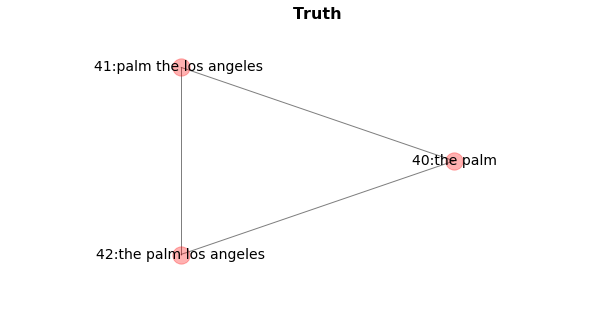

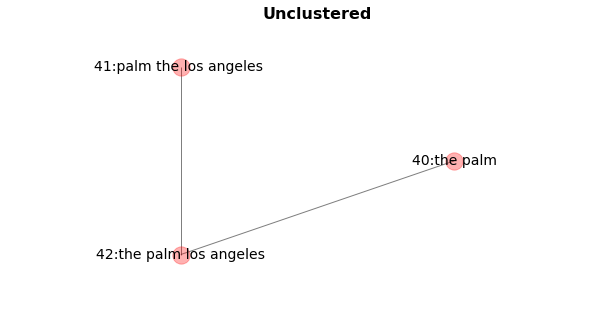

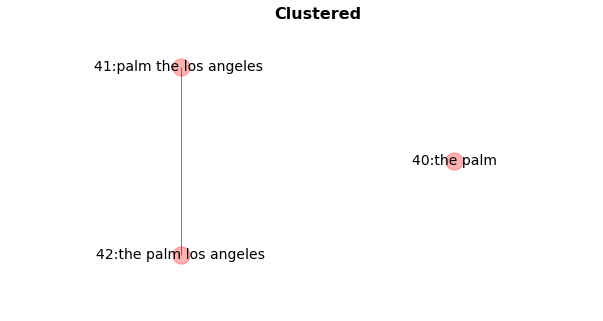

In [63]:
from graph_utils import show_cluster_graphs

bad_diff_all_ids = {40, 41, 42}
show_cluster_graphs(
    df,
    golden_pairs_set, dedupe_found_pairs_set, dedupe_unclustered_found_pairs_set,
    bad_diff_all_ids)

,name,addr,city,postal,lat,lng
120,petrossian,182 w. 58th st.,new york,10019,40.766049,-73.979439
121,petrossian,182 w. 58th st.,new york city,10019,40.766049,-73.979439
471,san pietro,18 e. 54th st.,new york,10022,40.760498,-73.974431


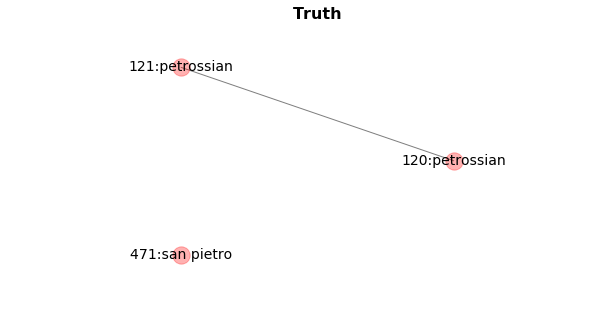

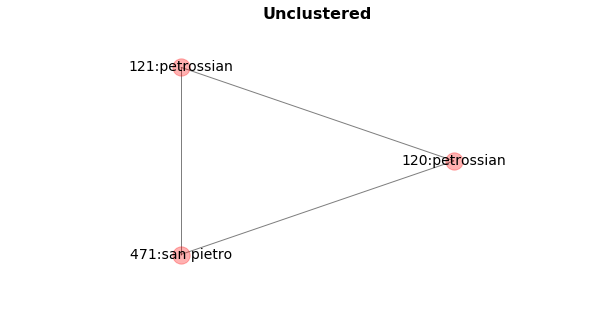

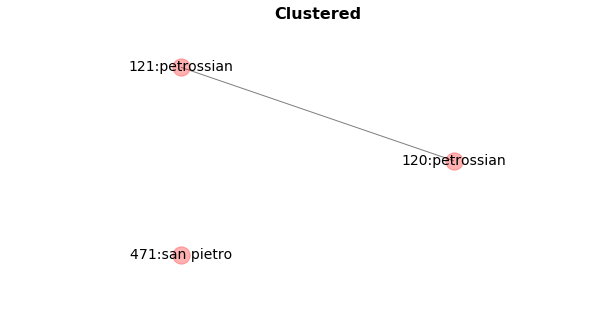

In [62]:
from graph_utils import show_cluster_graphs

good_diff_all_ids = {120, 121, 471}
show_cluster_graphs(
    df,
    golden_pairs_set, dedupe_found_pairs_set, dedupe_unclustered_found_pairs_set,
    good_diff_all_ids)

Remember the `recall_weight` parameter of the `deduper.threshold` method? That's what it controls: how aggressive we want to be on finding or dropping matches while clustering. Check Dedupe docs for more details on how it [performs clustering](https://docs.dedupe.io/en/latest/Grouping-duplicates.html) and how it computes [a good threshold](https://docs.dedupe.io/en/latest/Choosing-a-good-threshold.html#).

Finally, it's worth mentioning there's a web-based [product version of Dedupe](https://dedupe.io/). If you don't want to write code for deduping a dataset, check it.

<center><img src="https://dedupe.io/images/tutorials/getting-started-with-dedupe-io/img-5.jpg" width=800></center>

## Next Steps

Once we have the clusters, how to consolidate data from many records into one? Check for material on **Data Fusion**:
  - [Open issue at Python Record Linkage Toolkit](https://github.com/J535D165/recordlinkage/issues/27)
  - Christen, 6.12 Merging Matches [2]

What if new records arrive? Should we merge, unmerge, move records from clusters? Check for material on **Incremental Record Linkage**:
  - Dedupe approach is to either add to an existing cluster or create a new cluster. You can use a [Gazetteer](https://docs.dedupe.io/en/latest/API-documentation.html#gazetteer-objects) with previously deduped data, then merge new matches into it, and index new nonmatches.
  - Other approaches, check papers:
      * [Online Correlation Clustering](https://arxiv.org/pdf/1001.0920.pdf)
      * [Incremental Record Linkage](http://www.vldb.org/pvldb/vol7/p697-gruenheid.pdf)
      * [Heuristic-based approaches for speeding up incremental record linkage](https://www.sciencedirect.com/science/article/pii/S0164121217302972)

Also worth checking the **Privacy** implications of Record Linkage:
- Christen, chapter 8 [2]
- [k-anonymity](https://desfontain.es/privacy/k-anonymity.html), [k-map](https://desfontain.es/privacy/k-map.html), [δ-presence](https://desfontain.es/privacy/delta-presence.html)
- [Why differential privacy is awesome](https://desfontain.es/privacy/differential-privacy-awesomeness.html)

## References

- **Referenced by this talk**:
    * [1] [Mike Mull, The Art and Science of Data Matching](https://www.youtube.com/watch?v=Y-nYEOgq3YE) (slides [here](https://github.com/mikemull/Notebooks/blob/master/PyDataNYCSlides.ipynb))
    * [2] [Peter Christen, Data Matching](http://www.springer.com/us/book/9783642311635)
    * [3] [Mikhail Yuryevich Bilenko, Learnable Similarity Functions and Their Application to Record Linkage and Clustering](http://www.cs.utexas.edu/~ml/papers/marlin-dissertation-06.pdf)
- Other **talks** about Record Linkage with Python:
    * [Andrew Rowe, Big Data Deduplication and data matching using Python](https://www.youtube.com/watch?v=Z6mlvrYEYnk)
    * [Rhydwyn Mcguire, Record linkage: Join for real life](https://www.youtube.com/watch?v=cEcVIjyHfiQ)
- [Basics of Entity Resolution with Python and Dedupe](https://medium.com/district-data-labs/basics-of-entity-resolution-with-python-and-dedupe-bc87440b64d4)
- [Automating your Data Cleanup with Python](https://blog.kjamistan.com/automating-your-data-cleanup-with-python/)
- [Comparison of Data Matching software](https://github.com/J535D165/data-matching-software)
- [Compilation of Record Linkage resources](https://github.com/ropeladder/record-linkage-resources)

# Thank you!
flavio@vinta.com.br  
[@flaviojuvenal](https://twitter.com/flaviojuvenal)  
[vinta.com.br](https://www.vinta.com.br?dedupe-slides=1)

Special thanks to Russell Keith-Magee [@freakboy3742](https://twitter.com/freakboy3742), Forest Timothy Gregg [@forestgregg](https://twitter.com/forestgregg), and Jonathan de Bruin [@J535D165](https://github.com/J535D165).